In [1]:
from qTools import *
import Cahit as ck

import numpy as np

import matplotlib.pyplot as plt
import datetime

### System parameters

In [2]:
resonatorDimension = 200
g = 1.79
qfreq = 0
resFreq = 1

### Simulation Parameters and Settings

In [3]:
qSim = Simulation()
qSim.finalTime = 2
qSim.stepSize = 0.02
qSim.delStates = True

### Composite System Creation and Components

In [4]:
JCSys = QuantumSystem(name='JC')
RabiSys = QuantumSystem(name='Rabi')

cavJC = JCSys.addSubSys(Cavity(dimension=resonatorDimension, frequency=resFreq))
qubJC = JCSys.createSubSys(Qubit, frequency=qfreq)

#cavRabi = RabiSys.addSubSys(cavJC.copy())
cavRabi = RabiSys.addSubSys(cavJC.copy(),frequency=2*resFreq)
qubRabi = RabiSys.addSubSys(qubJC.copy())

Cavity requires a dimension
Qubit requires a dimension
Cavity requires a dimension
Qubit requires a dimension


#### Coupling term and initial state

In [5]:
JCcoupling = JCSys.JC(cavJC, qubJC, g)
RabiCoupling = RabiSys.Rabi(cavRabi, qubRabi, g)

#JCSys.initialState = [0,0]
cavJC.initialState = 0
qubJC.initialState = basis(2,0)

cavRabi.initialState = 0
qubRabi.initialState = basis(2,0)

### Define the Digital Algorithm

In [6]:
JCunitary = freeEvolution(ratio=0.5, superSys=JCSys)
#qubset = JCunitary.createUpdate(system=qubJC, key='frequency', value=0)

bitFlip = xGate(implementation='instant', superSys=qubJC)
#AJC = freeEvolution(superSys=JCSys)

#AJCunitary = qProtocol(steps=[bitFlip, AJC, bitFlip])
digitalRabi = qProtocol(superSys=JCSys, steps=[JCunitary, bitFlip, JCunitary, JCunitary, bitFlip, JCunitary], name='DigitalRabi')

### Add the systems into Simulation interface

In [7]:
qSim.addSubSys(JCSys, digitalRabi)
qSim.addSubSys(RabiSys)

### Define Parameter Sweeps

In [8]:
'''cavJCFreqSweep = qSim.Sweep.createSweep(system=cavJC, sweepKey='frequency', sweepList=np.arange(-2, 2+0.005, 0.005))
cavRabiFreqSweep = qSim.Sweep.createSweep(system=cavRabi, sweepKey='frequency', sweepList=np.arange(-4, 4+0.01, 0.01))'''
stepSizeSweep = qSim.Sweep.createSweep(system=qSim, sweepKey='stepSize', sweepList=np.arange(0.001,0.1,0.001))

### Define the (run-time) compute

In [9]:
cavParity = parityEXP(cavJC.freeMat)

def expectn(qSim, stateJC, stateRabi):
    
    #qSim.qRes.results['simFidelity'].append(fidelityKet(stateJC, stateRabi))
    #qSim.qRes.resultsMethod('simFidelity', fidelityKet(stateJC, stateRabi))
    qSim.qRes.resultsKeyValList = ['simFidelity', fidelityKet(stateJC, stateRabi)]
    qSim.qRes.averageKeyVal = ['simFidelityAve', fidelityKet(stateJC, stateRabi)]
    qSim.qRes.averageKeyVal = ['const', 1]

    #qSim.getResultByName('RabiResults').results['cavParity'].append(expectationKet(cavParity, stateRabi))
    #qSim.getResultByName('RabiResults').resultsMethod('cavParity', expectationKet(cavParity, stateRabi))
    qSim.getResultByName('RabiResults').resultsKeyValList = ('cavParity', expectationKet(cavParity, stateRabi))
    
    #qSim.getResultByName('JCDigitalRabiResults').results['cavParity'].append(expectationKet(cavParity, stateJC))
    #qSim.getResultByName('JCDigitalRabiResults').resultsMethod('cavParity', expectationKet(cavParity, stateJC))
    qSim.getResultByName('JCDigitalRabiResults').resultsKeyValList = ('cavParity', expectationKet(cavParity, stateJC))

qSim.compute = expectn

### Run the simulation

In [10]:
nw = datetime.datetime.now()

results = qSim.run(p=True, coreCount='all')

en = datetime.datetime.now()
print(en-nw)

0:00:31.628169


### Save Results

In [ ]:
path, fname = qSim.qRes.saveAll(fileName='trial', path='/Users/cahitkargi/Desktop')

### Plot the Results
---

Plotting is not part of the simulation library

In [ ]:
def plotRes(xList = cavRabiFreqSweep.sweepList):
    fig = plt.figure(figsize=(12,9))
    setC = [0.88, 0.25, 0.02, 0.6]

    axGrids = ck.Plotting.Functions.grid(3, 1, fig=fig)

    ck.Plotting.SimplePlots.colorPlot(xList, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.qRes.results['simFidelity'], ax=axGrids[0], gif=fig, setC=setC)
    ck.Plotting.SimplePlots.colorPlot(xList, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.getResultByName('RabiResults').results['cavParity'], ax=axGrids[1], gif=fig, setC=setC)
    ck.Plotting.SimplePlots.colorPlot(xList, [x*qSim.stepSize for x in range(qSim.steps+1)], qSim.getResultByName('JCDigitalRabiResults').results['cavParity'], ax=axGrids[2], gif=fig, setC=setC)

plotRes(cavRabiFreqSweep.sweepList)

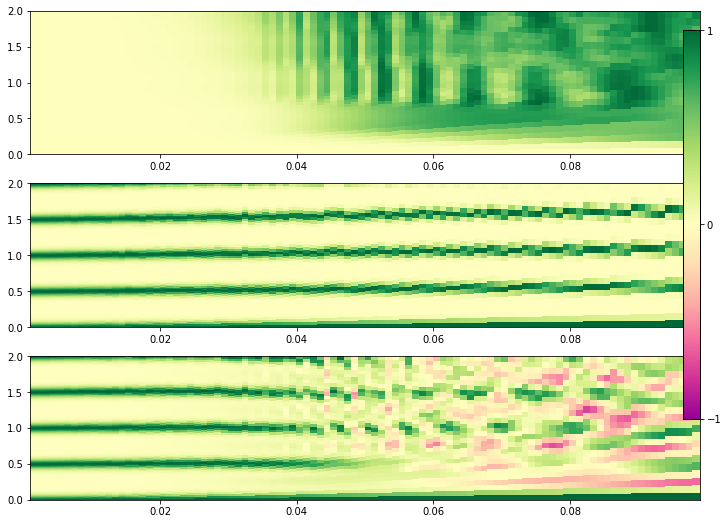

In [11]:
def plotRes(xList = stepSizeSweep.sweepList):
    fig = plt.figure(figsize=(12,9))
    setC = [0.88, 0.25, 0.02, 0.6]

    axGrids = ck.Plotting.Functions.grid(3, 1, fig=fig)

    ck.Plotting.SimplePlots.colorPlotIreg(xList, qSim.finalTime, qSim.qRes.results['simFidelity'], ax=axGrids[0], gif=fig, setC=setC, mapC='GrYl', maxC=1, minC=0)
    ck.Plotting.SimplePlots.colorPlotIreg(xList, qSim.finalTime, qSim.getResultByName('RabiResults').results['cavParity'], ax=axGrids[1], gif=fig, setC=setC)
    ck.Plotting.SimplePlots.colorPlotIreg(xList, qSim.finalTime, qSim.getResultByName('JCDigitalRabiResults').results['cavParity'], ax=axGrids[2], gif=fig, setC=setC)

plotRes()

In [13]:
print(len(qSim.qRes.results['simFidelityAve']))
print(qSim.qRes.results['simFidelityAve'])

99
[0.9999999491209157, 0.9999991857556447, 0.9999958706301829, 0.9999869421016833, 0.9999680536899099, 0.9999333306523368, 0.999876296897882, 0.9997885100985745, 0.9996574534050815, 0.9994784584055226, 0.9992303494443999, 0.9989005254993256, 0.9984770254765777, 0.9979345151716947, 0.9972332782216531, 0.9964155192901117, 0.9953567472514601, 0.9940425475416623, 0.9925222446919107, 0.9908068192890773, 0.9884918006297584, 0.9860778287022579, 0.9830723644810535, 0.9792256172811262, 0.9753247628948227, 0.9699913579884494, 0.9632967037228787, 0.9567431732351205, 0.9455359039050354, 0.938357603216213, 0.9246684200542219, 0.9090458790693191, 0.8933452501829029, 0.8779818480428755, 0.8111040115588243, 0.8458595152927694, 0.745783716515785, 0.8103268663490792, 0.7638719262383294, 0.5956431606206283, 0.7490398634282248, 0.7040582649809083, 0.5452257689413984, 0.4934766508196819, 0.7069637243396297, 0.5873568101668498, 0.410451634759148, 0.37450423339692396, 0.6594661836421568, 0.5919862494524858,

In [15]:
average = [sum(l)/len(l) for l in qSim.qRes.results['simFidelity']]

False


In [16]:
for i in range(len(average)):
    print(average[i] - qSim.qRes.results['simFidelityAve'][i])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-2.220446049250313e-16
0.0
0.0
0.0
3.3306690738754696e-16
0.0
0.0
-1.1102230246251565e-16
0.0
-5.551115123125783e-17
0.0
-2.220446049250313e-16
0.0
0.0
0.0
0.0
-1.1102230246251565e-16
0.0
5.551115123125783e-17
0.0
5.551115123125783e-17
0.0
0.0
0.0
0.0
1.1102230246251565e-16
0.0
0.0
-5.551115123125783e-17
0.0
-1.1102230246251565e-16
0.0
0.0
5.551115123125783e-17
0.0
1.1102230246251565e-16
0.0
0.0
0.0
0.0
0.0
0.0
1.6653345369377348e-16
0.0
5.551115123125783e-17
-5.551115123125783e-17
5.551115123125783e-17
0.0
5.551115123125783e-17
-5.551115123125783e-17
0.0
-5.551115123125783e-17
0.0
0.0
0.0
0.0
5.551115123125783e-17
0.0
0.0
-5.551115123125783e-17
0.0
0.0
